In [1]:
import pandas as pd

# Load the dataset. (Uploaded on my github repo)
df = pd.read_csv('https://raw.githubusercontent.com/shubhamhgnis91/nsl-kdd-ga/refs/heads/main/dataset.csv')

# display the first few rows
df.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [2]:
# make new column for attack. 0 for normal, 1 for attack
isAttack = df['attack'] != 'normal'
isAttack = isAttack.astype(int)
df['attackFlag'] = isAttack

df.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attackFlag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,0
1,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,1
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,0


In [3]:
from sklearn.calibration import LabelEncoder

# encode categorical features using one-hot encoding
featuresToEncode = ['protocol_type', 'service', 'flag']
df = pd.get_dummies(df, columns=featuresToEncode)

# encode attack column into numerical values
labelEncoder = LabelEncoder()
attackEncoder = LabelEncoder()
df['attack'] = attackEncoder.fit_transform(df["attack"])


In [4]:
from sklearn.model_selection import train_test_split

# drop the columns which are related to the target variable
X = df.drop(['attackFlag','level','attack'], axis=1)
y = df['attackFlag']

# split data into train and test sets
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
import numpy as np
from random import randint, random, sample

# parameters for the genetic algorithm
populationSize = 20
numGenerations = 15
crossoverRate = 0.8
mutationRate = 0.1
useElitism = True

In [6]:
# initialize lists for storing data for visualization
best_fitness_history = []
feature_size_history = []

In [7]:
# number of features to select for features
numFeatures = train_X.shape[1]

# initialize population with random feature selections (1 = selected, 0 = not selected)
population = np.random.randint(2, size=(populationSize, numFeatures))

In [8]:
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

# fitness function to evaluate a subset of features. 
def fitnessFunction(individual):

    # use only the selected features
    selectedFeatures = []

    for i in range(numFeatures):
        if individual[i] == 1:
            selectedFeatures.append(i)

    if not selectedFeatures:  # if no features selected, assign 0 fitness
        return 0

    # train a DecisionTreeClassifier with the selected features
    model = DecisionTreeClassifier()
    model.fit(train_X.iloc[:, selectedFeatures], train_y)
    predictions = model.predict(test_X.iloc[:, selectedFeatures])

    # use F1 score as the fitness metric for the selected features
    return f1_score(test_y, predictions)

# GA operations: selection, crossover, mutation, elitism
def selectParents(population, fitness):

    # tournament selection with 3 individuals
    parents = []
    for _ in range(2):
        tournament = sample(range(len(population)), k=3)

        tournamentFitness = []
        for i in tournament:
            tournamentFitness.append(fitness[i])

        bestIndividual = tournament[np.argmax(tournamentFitness)]
        
        parents.append(population[bestIndividual])
    return parents[0], parents[1]

# single-point crossover
def crossover(parent1, parent2):
    if random() < crossoverRate:
        point = randint(1, numFeatures - 1)
        child1 = np.concatenate([parent1[:point], parent2[point:]])
        child2 = np.concatenate([parent2[:point], parent1[point:]])
        return child1, child2
    return parent1, parent2

# mutation by flipping a bit
def adaptive_mutation(individual, generation, max_generations, mutationRate):
    # adaptive mutation rate that goes down over generations
    # in early generations: more exploration, higher mutation
    # in later generations: more exploitation, lower mutation
    adaptive_rate = mutationRate * (1 - generation / max_generations)
    
    # mutate individual with adaptive probability
    for i in range(len(individual)):
        if random() < adaptive_rate:
            individual[i] = 1 - individual[i]  # Bit flip
    
    # make sure at least one feature is always selected
    if np.sum(individual) == 0:
        individual[np.random.randint(len(individual))] = 1
    
    return individual

# adaptive mutation
def mutate(individual, generation, max_generations):
    return adaptive_mutation(individual, generation, max_generations, mutationRate)


In [9]:
# run GA
for generation in range(numGenerations):

    # evaluate fitness of each individual in the population
    fitness = []
    for individual in population:
        fitnessValue = fitnessFunction(individual)
        fitness.append(fitnessValue)

    fitness = np.array(fitness)

    # track best fitness
    best_fitness = np.max(fitness)
    best_fitness_history.append(best_fitness)

    # track feature size distribution
    feature_sizes = np.sum(population, axis=1)
    feature_size_history.append(feature_sizes)
    
    # elitism: keep the best individual
    if useElitism:
        best_index = np.argmax(fitness)
        best_individual = population[best_index].copy()
        best_fitness = fitness[best_index]
    
    # generate new population
    new_population = []
    while len(new_population) < populationSize:
        parent1, parent2 = selectParents(population, fitness)
        child1, child2 = crossover(parent1, parent2)
        
        # pass generation information to mutation
        child1 = mutate(child1, generation, numGenerations)
        child2 = mutate(child2, generation, numGenerations)
        
        new_population.extend([child1, child2])
    
    # ensure population size remains constant
    new_population = new_population[:populationSize]
    population = np.array(new_population)
    
    # replace worst individual with the best (elitism)
    if useElitism:        
        fitnessValues = []
        for ind in population:
            fitnessValue = fitnessFunction(ind)
            fitnessValues.append(fitnessValue)

        worst_index = np.argmin(fitnessValues)

        population[worst_index] = best_individual

    # print best fitness in each generation
    print(f"Generation {generation + 1}, Best F1 score: {best_fitness}")

Generation 1, Best F1 score: 0.9939619462191954
Generation 2, Best F1 score: 0.9945623574811436
Generation 3, Best F1 score: 0.9946302600638753
Generation 4, Best F1 score: 0.9949480774628123
Generation 5, Best F1 score: 0.9949106735460322
Generation 6, Best F1 score: 0.9947368421052633
Generation 7, Best F1 score: 0.9948073819381095
Generation 8, Best F1 score: 0.9949812234583933
Generation 9, Best F1 score: 0.9947034269879687
Generation 10, Best F1 score: 0.9950870297585628
Generation 11, Best F1 score: 0.995085650098287
Generation 12, Best F1 score: 0.9951222935747621
Generation 13, Best F1 score: 0.9953684210526317
Generation 14, Best F1 score: 0.9950514161372969
Generation 15, Best F1 score: 0.9951924764010247


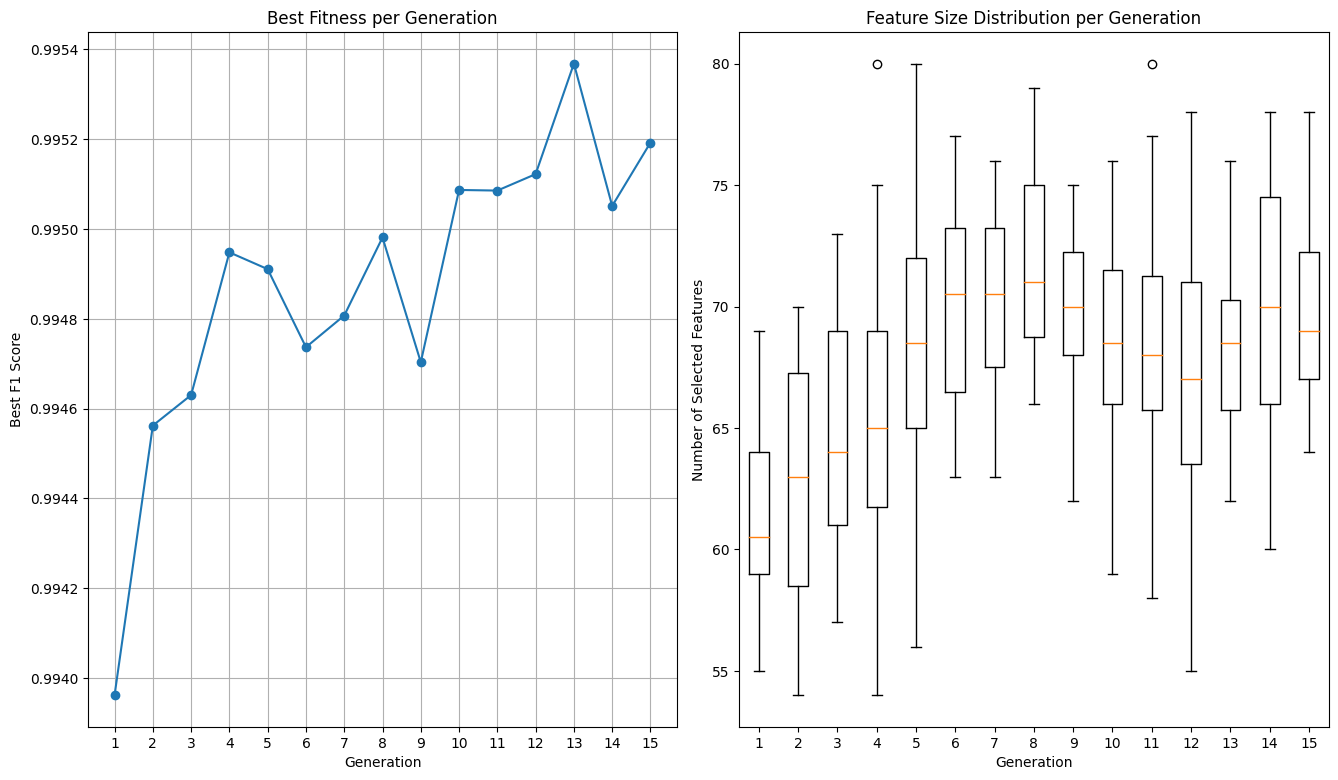

In [10]:
import matplotlib.pyplot as plt

# visualization plots
plt.figure(figsize=(20, 15))


# generation vs best fitness (f1-score) plot

plt.subplot(2, 3, 1)
plt.plot(range(1, numGenerations + 1), best_fitness_history, marker='o')
plt.title('Best Fitness per Generation')
plt.xlabel('Generation')
plt.ylabel('Best F1 Score')
plt.xticks(range(1, numGenerations + 1))
plt.grid(True)


# feature size distribution boxplot
plt.subplot(2, 3, 2)
feature_size_matrix = np.array(feature_size_history)
plt.boxplot(feature_size_matrix.T)
plt.title('Feature Size Distribution per Generation')
plt.xlabel('Generation')
plt.ylabel('Number of Selected Features')
plt.xticks(range(1, numGenerations + 1))

plt.tight_layout()
plt.show()

In [11]:
# after GA, select the best features
final_fitness = []
for individual in population:
    fitness_value = fitnessFunction(individual)
    final_fitness.append(fitness_value)

final_fitness = np.array(final_fitness)

best_solution = population[np.argmax(final_fitness)]

selected_features = []
for i, bit in enumerate(best_solution):
    if bit == 1:
        selected_features.append(i)


print("Selected Feature Indices:", selected_features)

Selected Feature Indices: [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 15, 16, 17, 19, 20, 21, 23, 24, 27, 28, 30, 31, 35, 36, 37, 39, 42, 43, 44, 46, 47, 48, 49, 51, 52, 53, 59, 60, 61, 64, 65, 68, 71, 73, 74, 77, 80, 81, 83, 84, 85, 86, 90, 91, 92, 93, 97, 103, 104, 106, 107, 108, 110, 111, 112, 113, 117, 119, 120]
